In [73]:
# Code inspired from https://bitbucket.org/EHR_Clustering/maspc/src/
# Imports
import numpy as np
import pandas as pd
import scipy
import subprocess
from sklearn import metrics
import csv
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator 


In [74]:
# Data input
initial_df = pd.read_csv("/home/kabank/workbench/.conda/analysis/kabank-data/diagnoses_atc_episode.csv")
final_episodes = pd.read_csv('/home/kabank/workbench/.conda/analysis/kabank-data/new-data/final_episodes.csv')
df = pd.merge(initial_df, final_episodes[["episode_id", "gender", "age_group"]], on='episode_id', how='inner')

In [75]:
df.shape

(11148, 6)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11148 entries, 0 to 11147
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   episode_id  11148 non-null  float64
 1   diagnoses   11148 non-null  object 
 2   atc_codes   11148 non-null  object 
 3   diag_atc    11148 non-null  object 
 4   gender      11148 non-null  int64  
 5   age_group   11148 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 522.7+ KB


In [77]:
# global variables
# emptyDF. Clustered data will be added here
clusteredData = pd.DataFrame() 
# Variable to be used for drawing dendogram
linkage_result = "" 
mfas = []

In [78]:
# Extract demographic information
demographic = df[["episode_id", "gender", "age_group"]]
# Binarize and one-hot encode demographic input
lb = LabelBinarizer()
ohe = OneHotEncoder()
demographic = demographic.join(pd.DataFrame(lb.fit_transform(demographic['age_group']),columns=lb.classes_ , index=demographic.index))

In [79]:
demographic.head()

,episode_id,gender,age_group,MiddleChildhood,Preschooler,Teenager
0,6.0,0,MiddleChildhood,1,0,0
1,7.0,0,Teenager,0,0,1
2,8.0,1,Teenager,0,0,1
3,9.0,1,Teenager,0,0,1
4,14.0,0,MiddleChildhood,1,0,0


In [80]:
# one-hot encode the 'gender' column and create new columns
one_hot = pd.get_dummies(df['gender'])
one_hot = one_hot.astype(int) 
one_hot.columns = ['F', 'M']
one_hot.head()


,F,M
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0


In [81]:
# concatenate the original dataframe with the one-hot encoded columns
demographic = pd.concat([demographic , one_hot], axis=1)
demographic = demographic.drop(["gender", "age_group"], axis=1)
demographic.head()

,episode_id,MiddleChildhood,Preschooler,Teenager,F,M
0,6.0,1,0,0,1,0
1,7.0,0,0,1,1,0
2,8.0,0,0,1,0,1
3,9.0,0,0,1,0,1
4,14.0,1,0,0,1,0


In [82]:
# Read diagnosesCodesAndAtc.txt as input for diagnosis codes
diagatc = open('/home/kabank/workbench/.conda/analysis/kabank-data/diagnosesCodesAndAtc.txt', 'r')
diag_atc = [line[:-2].split(' ') for line in diagatc.readlines()]

In [83]:
# -----------------------------------------
# Define Apriori algorithm
# The Apriori algorithm used at here is built upon SPMF (http://www. philippe -fournier -viger.com/spmf/)
# Please download spmf.jar from its website before you run Apriori algorithm
# Reference of Apriori: https://en.wikipedia.org/wiki/ Apriori_algorithm
# Input of Apriori is self._input = "***.txt", which includes each patients' diagnosis codes
# Output of Apriori is self._output = "***.txt"
class Apriori():

    def __init__(self):
        self._executable = "/home/kabank/workbench/.conda/analysis/main-scripts/spmf.jar" 
        self._input = "/home/kabank/workbench/.conda/analysis/kabank-data/diagnosesCodesAndAtc.txt"
        self._output = "Apriori_output.txt"
    def run(self, min_supp):
        subprocess.call(["java", "-Xmx512m", "-jar", self._executable ,"run", "Apriori", self._input , self._output ,str(min_supp)])
    def encode_input(self, data):
        pass
    def decode_output(self):
        # read
        lines = []
        try:
            with open(self._output, "r") as f:
                lines = f.readlines()
        except:
            print ("read_output error")

        # decode
        patterns = []
        for line in lines:
            line = line.strip()
            patterns.append(line.split())

        return patterns       

In [84]:
# -----------------------------------------
# Define FPMax algorithm
# FPMax Algorithm can return Frequent Maximal Itemsets
# Reference of FPMax Algorithm: Grahne, G., & Zhu, J. (2003, May). High performance mining of maximal frequent itemsets.
# Input of FPMax is self._input = "***.txt", which includes each patients' diagnosis codes
# Output of FPMax is self._output = "***.txt"
class FPMax():
    def __init__(self):
        self._executable = "/home/kabank/workbench/.conda/analysis/main-scripts/spmf.jar" 
        self._input = "/home/kabank/workbench/.conda/analysis/kabank-data/diagnosesCodesAndAtc.txt"
        self._output = "FPMax_output.txt"
    def run(self, min_supp):
        subprocess.call(["java", "-Xmx512m", "-jar", self._executable ,"run", "FPMax", self._input , self._output ,str(min_supp)])
    def encode_input(self, data): 
        pass
    def decode_output(self):
        # read
        lines = []
        try:
            with open(self._output , "r") as f:
                lines = f.readlines()
        except:
            print("read_output error2")
        # decode
        patterns = []
        for line in lines:
            line = line.strip() 
            patterns.append(line.split())
        return patterns
# -----------------------------------------
def allconfidence(list_1 , list_max):
    # Compute All_confidence of an itemset
    b = []
    for i in list_max[:len(list_max)-2]:
        for j in list_1: 
            if i == j[0]:
                b.append(int(j[2]))
    return int(list_max[-1])/max(b)

def get_all_allconfidence(list_1 , list_all_max , threshhold):
    # Input a list of MFIs
    # Return MFIs whose All_confidence is above minAc
    all_max = []
    for i in list_all_max:
        if allconfidence(list_1 , i) >= threshhold: 
            i[-1] = allconfidence(list_1 , i)
            all_max.append(i) 
    return all_max


In [85]:
# -----------------------------------------
# MASPC algorithm
class MASPC():
    def MAS(self, minSup, minAc, minOv): 
        # Run FPMax to get MFI
        fpmax = FPMax () 
        fpmax.encode_input([])
        fpmax.run(minSup)
        
        # Running Apriori is a preparatory step for getting MFA
        apriori = Apriori()
        apriori.encode_input([]) 
        apriori.run(minSup)
        list_1 = []
        for i in apriori.decode_output():
            if len(i) == 3: 
                list_1.append(i)

        # Get MFA
        all_con = get_all_allconfidence(list_1 , fpmax.decode_output(), minAc)
        all_con.sort(key=lambda x: x[-1], reverse=True)
        all_con_withoutSUP = []
        for i in all_con:
            all_con_withoutSUP.append([x for x in i[:len(i)-2]])
        all_con_target = []
        for i in all_con_withoutSUP: 
            flag = 0
            for j in all_con_target:
                if (set(i) & set(j) != set()):
                    number = 0
                    for k in diag_atc:
                        if ((set(k) & (set(i) | set(j))) == (set(i)| set(j))):
                            number = number + 1
                            if number <= minOv: 
                                flag = 1
                                break 
            if flag == 0:
                all_con_target.append(i)

        all_con_target_without1 = []

        for i in all_con_target: 
            if len(i) != 1:
                all_con_target_without1.append(i)

        # save MFAs
        self.MFAs = all_con_target_without1
        global mfas
        mfas = self.MFAs

In [86]:
class MASPC(MASPC):
    def PC(self, k, method, metric):
        w, h = len(self.MFAs), len(diag_atc) 
        all_con_tables_without1 = [[0 for x in range(w)] for y in range(h)]

        # project maximum set of independent frequnet patterns
        for i, j in enumerate(diag_atc):
            temp = set(j)

            l = len(temp)
            for a, b in enumerate(self.MFAs): 
                while (set(b) <= temp):
                    temp = temp.difference(set(b))

                    all_con_tables_without1[i][a] += 1

        # build a dataframe
        all_con_part_2_without1 = pd.DataFrame(all_con_tables_without1, columns=[str(sublist) for sublist in self.MFAs])
        all_con_final_t_without1 = demographic.join(all_con_part_2_without1)
        # delete the data that not be subscribed
        all_con_delete_without1= [sum(i) for i in all_con_tables_without1]
        all_con_delete_idex_without1=[i for i, e in enumerate(all_con_delete_without1) if e == 0]
        all_con_final_t_without1.drop(all_con_delete_idex_without1,inplace=True)
        self.binaryData = all_con_final_t_without1
        # do clustering
        # Replace all NaN values with a specific value (e.g., 0)
        all_con_final_t_without1.fillna(0, inplace=True)
        all_con_cos_ave_without1 = linkage(all_con_final_t_without1.drop("episode_id", axis=1).values, method, metric) 
        self.ClusterResult = fcluster(all_con_cos_ave_without1 , k, criterion='maxclust')

        global linkage_result
        linkage_result = all_con_cos_ave_without1

        global clusteredData
        clusteredData = all_con_final_t_without1

        

In [87]:
import warnings
warnings.filterwarnings("ignore")
# -----------------------------------------
def Run_MASPC_calculate_CI_SI(K, minSup, minAc, minOv):
    # Run MASPC
    # Input parameters: minSup=0.03, minAc=0.03, minOv=10, k=31
    # method='average' and metric='cosine' are parameters for agglomerative average -linkage hierarchical clustering
    if __name__ == "__main__": 
        maspc = MASPC()
        maspc.MAS(minSup=minSup, minAc=minAc, minOv=minOv)
        maspc.PC(k=K, method='average', metric='cosine')

    # Add label to binary representation
    maspc.binaryData['label'] = maspc.ClusterResult
    # -----------------------------------------
    # Preparation for SI and CI calculation
    # Get all unique diagnosis codes and build a binary representation for evaluation
    allUniqueCodes = []
    for i in diag_atc:
        for j in i: 
            allUniqueCodes.append(j)
    allUniqueCodes = list(set(allUniqueCodes))
    new_list = [allUniqueCodes[i:i+1] for i in range(0, len(allUniqueCodes), 1)]
    w, h = len(allUniqueCodes), len(diag_atc) 
    atables = [[0 for x in range(w)] for y in range(h)]

    # project maximum set of independent frequnet patterns
    for i, j in enumerate(diag_atc): 
        temp = set(j)
        for a, b in enumerate(new_list): 
            while (set(b) <= temp):
                temp = temp.difference(set(b)) 
                atables[i][a] += 1

    diga_codes = pd.DataFrame(atables, columns=[str(sublist) for sublist in allUniqueCodes])
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    label_df = clusteredData.loc[:, ['episode_id','label']]
    demographicClusteredData = clusteredData.iloc[:, 0:6]
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    temp_df = pd.merge(df, diga_codes, left_index=True, right_index=True )
    temp_df = temp_df.drop(["gender", "age_group", "diagnoses", "atc_codes", "diag_atc"],axis =1) 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    eval_df = demographicClusteredData.merge(temp_df, on='episode_id', how='inner')
    eval_df = eval_df.merge(label_df, on='episode_id', how='inner') 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    eval_df = eval_df.drop('episode_id', axis=1)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    label_df = eval_df.loc[:, ['label']]
    eval_df = eval_df.drop('label', axis=1)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # SI and CI calculation
    CI = metrics.calinski_harabasz_score(eval_df, label_df)
    SI = metrics.silhouette_score(eval_df, label_df, metric='cosine')
    binaryData_df = pd.DataFrame(maspc.binaryData)
    return round(CI, 2), round(SI, 2), binaryData_df


# finding best K(s)

In [88]:
minSup = 0.03
minAc = 0.03
minOv = 10
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results = []
# Create an empty dataframe
results_df = pd.DataFrame(columns=['K', 'minSup', 'minAc', 'minOv', 'CI_Score', 'SI_Score'])

for K in range(10,26):
    # Call the function and get CI_result, SI_result
    CI_Score, SI_Score, binaryData_df = Run_MASPC_calculate_CI_SI(K, minSup, minAc, minOv)
    
    # Append the results to the list
    results.append({'K': K, 'minSup': minSup , 'minAc' : minAc, 'minOv' : minOv, 'CI_Score': CI_Score, 'SI_Score': SI_Score})

results_df = pd.DataFrame(results)
# Print or save the dataframe for later use
print(results_df)



     K  minSup  minAc  minOv  CI_Score  SI_Score
0   10    0.03   0.03     10    109.71      0.32
1   11    0.03   0.03     10    102.67      0.32
2   12    0.03   0.03     10    102.67      0.36
3   13    0.03   0.03     10    102.67      0.36
4   14    0.03   0.03     10    102.67      0.36
5   15    0.03   0.03     10    102.67      0.36
6   16    0.03   0.03     10    102.67      0.36
7   17    0.03   0.03     10    102.67      0.36
8   18    0.03   0.03     10    102.67      0.36
9   19    0.03   0.03     10     96.48      0.35
10  20    0.03   0.03     10     89.40      0.34
11  21    0.03   0.03     10     89.40      0.34
12  22    0.03   0.03     10     89.40      0.34
13  23    0.03   0.03     10     74.97      0.31
14  24    0.03   0.03     10     74.97      0.31
15  25    0.03   0.03     10     74.97      0.31


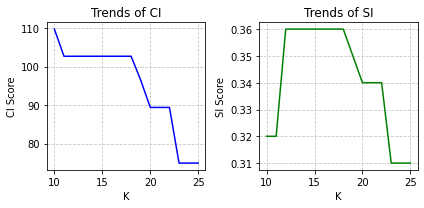

In [89]:
import matplotlib.pyplot as plt

# Assuming you have extracted K values and CI/SI results as shown in the previous response

# Create a figure with two subplots arranged side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
K_values = results_df['K']
CI_Score = results_df['CI_Score']
SI_Score = results_df['SI_Score']
# Plot CI values
ax1.plot(K_values, CI_Score, label='CI', color='blue')
ax1.set_xlabel('K')
ax1.set_ylabel('CI Score')
ax1.set_title('Trends of CI')
ax1.grid(True, linestyle='--', alpha=0.7)
#ax1.legend()

# Plot SI values
ax2.plot(K_values, SI_Score, label='SI', color='green')
ax2.set_xlabel('K')
ax2.set_ylabel('SI Score')
ax2.set_title('Trends of SI')
ax2.grid(True, linestyle='--', alpha=0.7)
#ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
# best K(s) are between 15 - 21

# finding best minSup

In [90]:

minAc = 0.03
minOv = 10
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results = []
# Create an empty dataframe
results_df = pd.DataFrame(columns=['K', 'minSup', 'minAc', 'minOv', 'CI_Score', 'SI_Score'])
for minSup in range(1, 10, 1):
    minSup = minSup/100
    for K in range(10,22):
        # Call the function and get CI_result, SI_result
        CI_Score, SI_Score, binaryData_df = Run_MASPC_calculate_CI_SI(K, minSup, minAc, minOv)
        
        # Append the results to the list
        results.append({'K': K, 'minSup': minSup , 'minAc' : minAc, 'minOv' : minOv, 'CI_Score': CI_Score, 'SI_Score': SI_Score})

    results_df = pd.DataFrame(results)
    # Print or save the dataframe for later use
    print(results_df)



     K  minSup  minAc  minOv  CI_Score  SI_Score
0   10    0.01   0.03     10     33.44      0.11
1   11    0.01   0.03     10     32.88      0.11
2   12    0.01   0.03     10     30.77      0.11
3   13    0.01   0.03     10     30.58      0.09
4   14    0.01   0.03     10     30.20      0.09
5   15    0.01   0.03     10     28.67      0.06
6   16    0.01   0.03     10     28.10      0.05
7   17    0.01   0.03     10     27.44      0.04
8   18    0.01   0.03     10     27.13      0.06
9   19    0.01   0.03     10     26.50      0.06
10  20    0.01   0.03     10     26.57      0.07
11  21    0.01   0.03     10     27.88      0.09
     K  minSup  minAc  minOv  CI_Score  SI_Score
0   10    0.01   0.03     10     33.44      0.11
1   11    0.01   0.03     10     32.88      0.11
2   12    0.01   0.03     10     30.77      0.11
3   13    0.01   0.03     10     30.58      0.09
4   14    0.01   0.03     10     30.20      0.09
5   15    0.01   0.03     10     28.67      0.06
6   16    0.01   0.0

In [91]:
results_df['K'].min() # 15
results_df['K'].max() #21
results_df['minSup'].min() #0.01
results_df['minSup'].max() #0.09

0.09

In [92]:
K_values = results_df['K']
minSup_values = results_df['minSup']
CI_Score = results_df['CI_Score']
SI_Score = results_df['SI_Score']

In [93]:
results_df

,K,minSup,minAc,minOv,CI_Score,SI_Score
0,10,0.01,0.03,10,33.44,0.11
1,11,0.01,0.03,10,32.88,0.11
2,12,0.01,0.03,10,30.77,0.11
3,13,0.01,0.03,10,30.58,0.09
4,14,0.01,0.03,10,30.20,0.09
...,...,...,...,...,...,...
103,17,0.09,0.03,10,489.49,0.48
104,18,0.09,0.03,10,489.49,0.48
105,19,0.09,0.03,10,489.49,0.48
106,20,0.09,0.03,10,489.49,0.48


In [94]:
minSup_values = results_df['minSup']
minSup_values.unique()

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

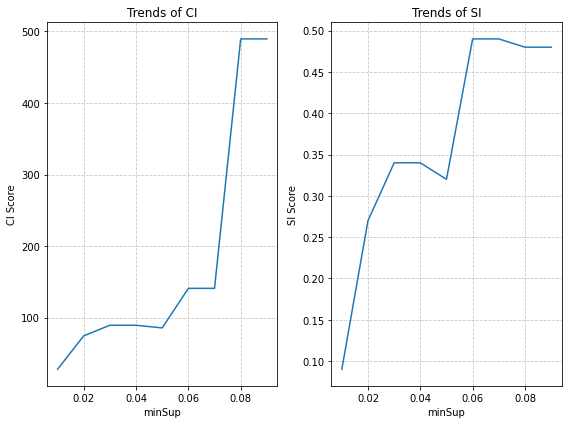

In [95]:
CI_list =[]
SI_list =[]
K_list = []
minSup_list = []
minSup_values = results_df['minSup']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

for minSup in minSup_values:
    CI_list.append(results_df[(results_df['minSup'] == minSup) & (results_df['K'] == 21)]['CI_Score'])
    SI_list.append(results_df[(results_df['minSup'] == minSup) & (results_df['K'] == 21)]['SI_Score'])
    minSup_list.append(minSup)

# Plot CI values
ax1.plot(minSup_list, CI_list)

# Plot SI values
ax2.plot(minSup_list, SI_list)

# Set labels, titles, and legends
ax1.set_xlabel('minSup')
ax1.set_ylabel('CI Score')
ax1.set_title('Trends of CI')
ax1.grid(True, linestyle='--', alpha=0.7)
#ax1.legend()

ax2.set_xlabel('minSup')
ax2.set_ylabel('SI Score')
ax2.set_title('Trends of SI')
ax2.grid(True, linestyle='--', alpha=0.7)
#ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# best minSup seems like 0.06

# finding best minAc

In [96]:
minSup = 0.09
minOv = 10

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results = []
# Create an empty dataframe
results_df2 = pd.DataFrame(columns=['K', 'minSup', 'minAc', 'minOv', 'CI_Score', 'SI_Score'])
for minAc in range(1, 10, 1):
    minAc = minAc/100
    for K in range(11,22):
        # Call the function and get CI_result, SI_result
        CI_Score, SI_Score, binaryData_df = Run_MASPC_calculate_CI_SI(K, minSup, minAc, minOv)
        
        # Append the results to the list
        results.append({'K': K, 'minSup': minSup , 'minAc' : minAc, 'minOv' : minOv, 'CI_Score': CI_Score, 'SI_Score': SI_Score})

    results_df2 = pd.DataFrame(results)
    # Print or save the dataframe for later use
    print(results_df2)



     K  minSup  minAc  minOv  CI_Score  SI_Score
0   11    0.09   0.01     10    489.49      0.48
1   12    0.09   0.01     10    489.49      0.48
2   13    0.09   0.01     10    489.49      0.48
3   14    0.09   0.01     10    489.49      0.48
4   15    0.09   0.01     10    489.49      0.48
5   16    0.09   0.01     10    489.49      0.48
6   17    0.09   0.01     10    489.49      0.48
7   18    0.09   0.01     10    489.49      0.48
8   19    0.09   0.01     10    489.49      0.48
9   20    0.09   0.01     10    489.49      0.48
10  21    0.09   0.01     10    489.49      0.48
     K  minSup  minAc  minOv  CI_Score  SI_Score
0   11    0.09   0.01     10    489.49      0.48
1   12    0.09   0.01     10    489.49      0.48
2   13    0.09   0.01     10    489.49      0.48
3   14    0.09   0.01     10    489.49      0.48
4   15    0.09   0.01     10    489.49      0.48
5   16    0.09   0.01     10    489.49      0.48
6   17    0.09   0.01     10    489.49      0.48
7   18    0.09   0.0

In [97]:
results_df2

,K,minSup,minAc,minOv,CI_Score,SI_Score
0,11,0.09,0.01,10,489.49,0.48
1,12,0.09,0.01,10,489.49,0.48
2,13,0.09,0.01,10,489.49,0.48
3,14,0.09,0.01,10,489.49,0.48
4,15,0.09,0.01,10,489.49,0.48
...,...,...,...,...,...,...
94,17,0.09,0.09,10,489.49,0.48
95,18,0.09,0.09,10,489.49,0.48
96,19,0.09,0.09,10,489.49,0.48
97,20,0.09,0.09,10,489.49,0.48


In [98]:
minAc_values = results_df2['minAc']
minAc_values.unique()

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

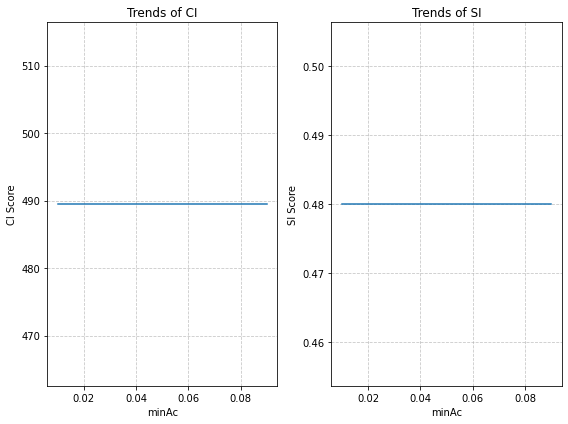

In [99]:
CI_list =[]
SI_list =[]
K_list = []
minAc_list = []
minAc_values = results_df2['minAc']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

for minAc in minAc_values:
    CI_list.append(results_df2[(results_df2['minAc'] == minAc)  & (results_df2['K'] == 11)]['CI_Score'])
    SI_list.append(results_df2[(results_df2['minAc'] == minAc) & (results_df2['K'] == 11)]['SI_Score'])
    minAc_list.append(minAc)

# Plot CI values
ax1.plot(minAc_list, CI_list)

# Plot SI values
ax2.plot(minAc_list, SI_list)

# Set labels, titles, and legends
ax1.set_xlabel('minAc')
ax1.set_ylabel('CI Score')
ax1.set_title('Trends of CI')
ax1.grid(True, linestyle='--', alpha=0.7)
#ax1.legend()

ax2.set_xlabel('minAc')
ax2.set_ylabel('SI Score')
ax2.set_title('Trends of SI')
ax2.grid(True, linestyle='--', alpha=0.7)
#ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
#It seems adjusting the different values for minAc does not result in any changes in the CI, SI scores.


# finding best minOv

In [100]:
minSup = 0.09
minAc = 0.03
minOv = 10
K=11
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
results = []
# Create an empty dataframe
results_df3 = pd.DataFrame(columns=['K', 'minSup', 'minAc', 'minOv', 'CI_Score', 'SI_Score'])
minOv_values = [5,   155,  304,   455,  603,   753,  902,  1052, 1201,  1351, 1500]
for minOv in minOv_values:
    minOv = minOv/100
#    for K in range(11,22):
        # Call the function and get CI_result, SI_result
    CI_Score, SI_Score, binaryData_df = Run_MASPC_calculate_CI_SI(K, minSup, minAc, minOv)
        
        # Append the results to the list
    results.append({'K': K, 'minSup': minSup , 'minAc' : minAc, 'minOv' : minOv, 'CI_Score': CI_Score, 'SI_Score': SI_Score})

    results_df3 = pd.DataFrame(results)
    # Print or save the dataframe for later use
    print(results_df3)



    K  minSup  minAc  minOv  CI_Score  SI_Score
0  11    0.09   0.03   0.05     324.4      0.42
    K  minSup  minAc  minOv  CI_Score  SI_Score
0  11    0.09   0.03   0.05    324.40      0.42
1  11    0.09   0.03   1.55    489.49      0.48
    K  minSup  minAc  minOv  CI_Score  SI_Score
0  11    0.09   0.03   0.05    324.40      0.42
1  11    0.09   0.03   1.55    489.49      0.48
2  11    0.09   0.03   3.04    489.49      0.48
    K  minSup  minAc  minOv  CI_Score  SI_Score
0  11    0.09   0.03   0.05    324.40      0.42
1  11    0.09   0.03   1.55    489.49      0.48
2  11    0.09   0.03   3.04    489.49      0.48
3  11    0.09   0.03   4.55    489.49      0.48
    K  minSup  minAc  minOv  CI_Score  SI_Score
0  11    0.09   0.03   0.05    324.40      0.42
1  11    0.09   0.03   1.55    489.49      0.48
2  11    0.09   0.03   3.04    489.49      0.48
3  11    0.09   0.03   4.55    489.49      0.48
4  11    0.09   0.03   6.03    489.49      0.48
    K  minSup  minAc  minOv  CI_Score  S

In [101]:
minOv_values = results_df3['minOv'].unique()
print(minOv_values)

[ 0.05  1.55  3.04  4.55  6.03  7.53  9.02 10.52 12.01 13.51 15.  ]


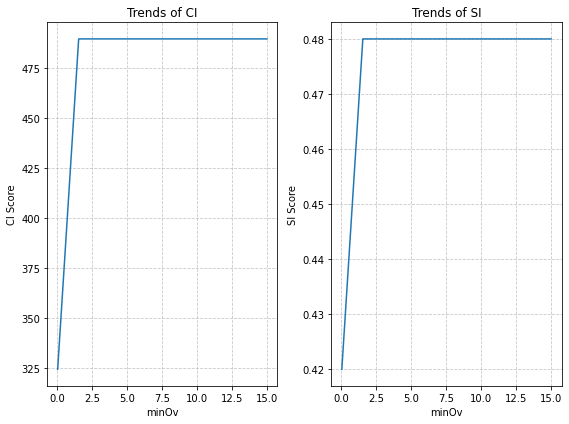

In [102]:
CI_list =[]
SI_list =[]
K_list = []
minOv_list = []
minOv_values = results_df3['minOv'].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

for minOv in minOv_values:
    CI_list.append(results_df3[(results_df3['minOv'] == minOv) & (results_df3['minAc'] == 0.03) & (results_df3['minSup'] == 0.09) & (results_df3['K'] == 11)]['CI_Score'])
    SI_list.append(results_df3[(results_df3['minOv'] == minOv) & (results_df3['minAc'] == 0.03) & (results_df3['minSup'] == 0.09) & (results_df3['K'] == 11)]['SI_Score'])
    minOv_list.append(minOv)

# Plot CI values
ax1.plot(minOv_list, CI_list, label=f'minOv={minOv}')

# Plot SI values
ax2.plot(minOv_list, SI_list, label=f'minOv={minOv}')

# Set labels, titles, and legends
ax1.set_xlabel('minOv')
ax1.set_ylabel('CI Score')
ax1.set_title('Trends of CI')
ax1.grid(True, linestyle='--', alpha=0.7)
#ax1.legend()

ax2.set_xlabel('minOv')
ax2.set_ylabel('SI Score')
ax2.set_title('Trends of SI')
ax2.grid(True, linestyle='--', alpha=0.7)
#ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
#It seems any values between 1 to 15 or bigger for minOv, can work well.


# best values for parameters: 
K= 11
minSup=0.09
minAc=0.03
minOv=0.95

In [103]:
CI_Score, SI_Score, binaryData_df = Run_MASPC_calculate_CI_SI(K=11, minSup=0.06, minAc=0.03, minOv=0.99)
print(f'CI Score: {CI_Score}')
print(f'SI Score: {SI_Score}')
print(f'Number of maximal itemsets:{len(mfas)}')

CI Score: 178.46
SI Score: 0.24
Number of maximal itemsets:4


In [104]:
CI_Score, SI_Score, binaryData_df = Run_MASPC_calculate_CI_SI(K=11, minSup=0.09, minAc=0.03, minOv=0.99)
print(f'CI Score: {CI_Score}')
print(f'SI Score: {SI_Score}')
print(f'Number of maximal itemsets:{len(mfas)}')

CI Score: 324.4
SI Score: 0.42
Number of maximal itemsets:2


In [105]:
CI_Score, SI_Score, binaryData_df= Run_MASPC_calculate_CI_SI(K=11, minSup=0.03, minAc=0.03, minOv=0.99)
print(f'CI Score: {CI_Score}')
print(f'SI Score: {SI_Score}')
print(f'Number of maximal itemsets:{len(mfas)}')

CI Score: 141.08
SI Score: 0.11
Number of maximal itemsets:13


In [106]:
mfas

[['29622', '999140601'],
 ['29622', '3001'],
 ['3001', '999140601'],
 ['3131', '999140602', '999140503'],
 ['3131', '999140602', '999010602'],
 ['3131', '999140602', '3151'],
 ['3131', '999140602', '3132'],
 ['3131', '313'],
 ['3131', '3133'],
 ['3131', '3001'],
 ['3131', '999140602', '999140501'],
 ['3131', '29622'],
 ['3131', '312']]

# -----------------------------------------
Clustering Result Plots
# -----------------------------------------

In [107]:
# Imports
import pickle as pkl
import re
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns
import shap
from tqdm import tqdm
from lightgbm import LGBMClassifier

In [108]:
k=11
heat_map_AGEGROUP = np.zeros([3, k]) 
heat_map_GENDER = np.zeros([2, k])
heat_map_MFAs = np.zeros([len(mfas), k])
barplot_GENDER = np.zeros([2, k])
num_episodes_each_cluster_list = []

In [113]:
# Calculate values for plots
for i in range(0, k):
    if i + 1 in binaryData_df['label'].unique():  # Check if the group exists
        group_df = binaryData_df.groupby(['label']).get_group(i + 1)
        num_episodes_in_group = len(group_df)
        num_episodes_each_cluster_list.append(num_episodes_in_group)
    else:
        # Handle the case where the group does not exist (optional)
        num_episodes_each_cluster_list.append(0)

    # Calculate gender distribution in number
    barplot_GENDER[0][i] = len(group_df[group_df["F"] == 1])
    barplot_GENDER[1][i] = len(group_df[group_df["M"] == 1])

    # Calculating the percentage of each gender in each group, 0 = Female , 1 = Male
    heat_map_GENDER[0][i] = len(group_df[group_df["F"] == 1])/num_episodes_in_group
    heat_map_GENDER[1][i] = len(group_df[group_df["M"] == 1])/num_episodes_in_group

    # Calculating the percentage of age groups in each group
    heat_map_AGEGROUP[0][i] = len( group_df[group_df["Preschooler"] == 1])/num_episodes_in_group 
    heat_map_AGEGROUP[1][i] = len(group_df[group_df["MiddleChildhood"] == 1])/ num_episodes_in_group
    heat_map_AGEGROUP[2][i] = len(group_df[group_df["Teenager"] == 1])/num_episodes_in_group

    for mfa in range(len(mfas)):
        heat_map_MFAs[mfa][i] = len( group_df[group_df.iloc[:, 6 + mfa] == 1])/num_episodes_in_group


In [114]:
print(mfas)

[['29622', '999140601'], ['29622', '3001'], ['3001', '999140601'], ['3131', '999140602', '999140503'], ['3131', '999140602', '999010602'], ['3131', '999140602', '3151'], ['3131', '999140602', '3132'], ['3131', '313'], ['3131', '3133'], ['3131', '3001'], ['3131', '999140602', '999140501'], ['3131', '29622'], ['3131', '312']]


In [115]:
print(len(mfas))

13


In [116]:
# Decode labels to text, so that it is not only numbers
mfa_text = clusteredData.columns[6:len(mfas)+6]
plot_labels = []
with open('/home/kabank/workbench/.conda/analysis/kabank-data/alphabet_dict.pkl', 'rb') as a_dict:
    alphabet_dict = pkl.load(a_dict)
reverse_alphabet_dict = {} 
for i in range(26):
    letter = chr(i + ord('A')) 
    if i < 9:
        reverse_alphabet_dict["0" + str(i+1)] = letter 
    else:
        reverse_alphabet_dict[str(i+1)] = letter

with open('/home/kabank/workbench/.conda/analysis/kabank-data/phecodes_dict.pkl', 'rb') as p_dict:
    phecodes_dict = pkl.load(p_dict)
reverse_phecodes_dict = {}
for item in phecodes_dict.values(): 
    reverse_phecodes_dict[str(item[0]).replace(".", "")] = item[1]
for labels in mfa_text:
    labels_list = labels.replace("[", "").replace("]", "").replace( "'", "").replace(" ", "").split(",")
    one_mfa_labels = []

for label in labels_list: 
    if label[0:3] == "999":
        atc = label [3:]
        atc_string = reverse_alphabet_dict[atc[0:2]] + atc[2:4] + reverse_alphabet_dict[atc[4:]] 
        one_mfa_labels.append(atc_string)
    else:
        diagnosis = reverse_phecodes_dict[label]
        one_mfa_labels.append(diagnosis) 

plot_labels.append(one_mfa_labels)

In [117]:
# Create a color scale for bar plot so that large values have similar colors
# Inspired from here: https://stackoverflow.com/a/60917129
def colors_from_values(values , palette_name):
# normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name , len(values)) 
    return np.array(palette).take(indices, axis=0)

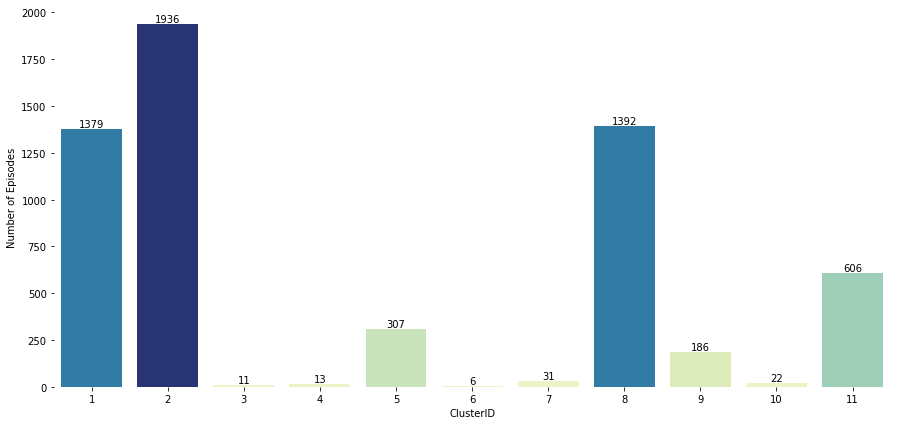

In [118]:
# Bar chart showing number of episodes in each cluster
plt.figure(figsize=(15, 7))
x_vals = np.arange(1, k+1)
y_vals = num_episodes_each_cluster_list
ax = sns.barplot(x=x_vals , y=y_vals , palette=colors_from_values( pd.Series(y_vals), "YlGnBu"), )
ax.set_ylabel("Number of Episodes")
ax.set_xlabel("ClusterID") 
ax.bar_label(ax.containers[0])
sns.despine(left=True, bottom=True)
#plt.savefig('/home/kabank/workbench/.conda/analysis/ias_Diagrams/numEpisodesClusterBARPLOT.pdf', bbox_inches="tight")

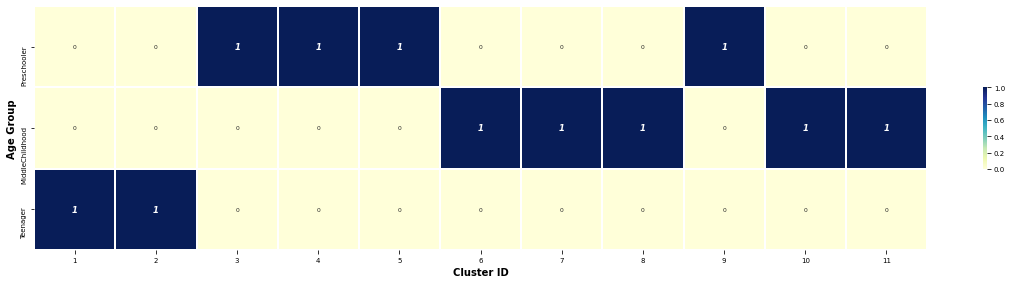

In [119]:
# Heatmap for age group
plt.figure(3, figsize=(20, 5)) 
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7) 
plt.rc('axes', labelsize=10, linewidth=1)
y_axis_labels = ["Preschooler", "MiddleChildhood", "Teenager"] 
x_axis_labels = list(range(1, k+1))
ax = sns.heatmap(np.round(heat_map_AGEGROUP , 2), cmap="YlGnBu", square=True, annot=True, fmt=".2g", annot_kws={"fontsize": 7},cbar=True, cbar_kws={"shrink": .3}, linewidths=.1, xticklabels=x_axis_labels , yticklabels=y_axis_labels)
plt.xlabel('Cluster ID', fontweight='bold') 
plt.ylabel('Age Group', fontweight='bold')
for text in ax.texts:
    text.set_size(6)
    if float(text.get_text()) >= 0.5:
        text.set_size(8.5) 
        text.set_weight('bold')
        text.set_style('italic')
#plt.savefig('/home/kabank/workbench/.conda/analysis/ias_Diagrams/ageGroupHEATMAP.pdf', bbox_inches="tight")

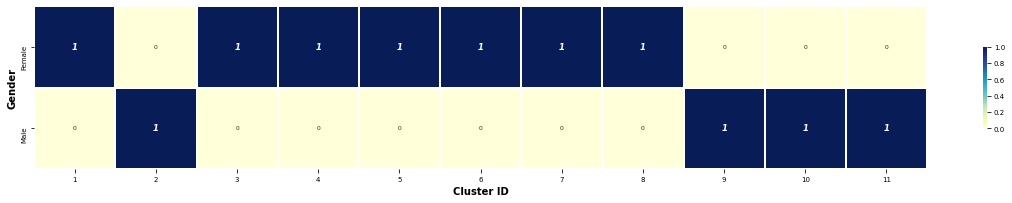

In [120]:
# Heatmap for gender
plt.figure(figsize=(20, 5)) 
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7) 
plt.rc('axes', labelsize=10, linewidth=1)
y_axis_labels = ["Female", "Male"]
x_axis_labels = list(range(1, k+1))
ax = sns.heatmap(np.round(heat_map_GENDER , 2), cmap="YlGnBu", square=True, annot=True, fmt=".2g", annot_kws={"fontsize": 7}, cbar=True, cbar_kws={"shrink": .3}, linewidths=.1,
xticklabels=x_axis_labels , yticklabels=y_axis_labels)
plt.xlabel('Cluster ID', fontweight='bold')
plt.ylabel('Gender', fontweight='bold')
for text in ax.texts: 
    text.set_size(6)
    if float(text.get_text()) >= 0.5: 
        text.set_size(8.5)
        text.set_weight('bold') 
        text.set_style('italic')
#plt.savefig('/home/kabank/workbench/.conda/analysis/ias_Diagrams//genderHEATMAP.pdf', bbox_inches="tight")

In [121]:
# Decode labels to text, so that it is not only numbers
mfa_text = clusteredData.columns[6:len(mfas)+6]
plot_labels = []
print(mfa_text)

Index(['['29622', '999140601']', '['29622', '3001']', '['3001', '999140601']',
       '['3131', '999140602', '999140503']',
       '['3131', '999140602', '999010602']', '['3131', '999140602', '3151']',
       '['3131', '999140602', '3132']', '['3131', '313']', '['3131', '3133']',
       '['3131', '3001']', '['3131', '999140602', '999140501']',
       '['3131', '29622']', '['3131', '312']'],
      dtype='object')


In [122]:
# Every number represents a letter
with open('/home/kabank/workbench/.conda/analysis/Resources/alphabet_dict.pkl', 'rb') as a_dict:
    alphabet_dict = pkl.load(a_dict)
reverse_alphabet_dict = {} 
for i in range(26):
    letter = chr(i + ord('A')) 
    if i < 9:
        reverse_alphabet_dict["0" + str(i+1)] = letter 
    else:
        reverse_alphabet_dict[str(i+1)] = letter

In [123]:
print(reverse_alphabet_dict)

{'01': 'A', '02': 'B', '03': 'C', '04': 'D', '05': 'E', '06': 'F', '07': 'G', '08': 'H', '09': 'I', '10': 'J', '11': 'K', '12': 'L', '13': 'M', '14': 'N', '15': 'O', '16': 'P', '17': 'Q', '18': 'R', '19': 'S', '20': 'T', '21': 'U', '22': 'V', '23': 'W', '24': 'X', '25': 'Y', '26': 'Z'}


In [124]:
with open('/home/kabank/workbench/.conda/analysis/Resources/phecodes_dict.pkl', 'rb') as p_dict:
    phecodes_dict = pkl.load(p_dict) # In phecode_dict, every disorder is represented by a phecode, like: 'A00': ['008', 'Intestinal infection', 'Intestinal infection']
reverse_phecodes_dict = {} # it converts every phecode to a disorder
for item in phecodes_dict.values():  
    reverse_phecodes_dict[str(item[0]).replace(".", "")] = item[0]

reverse_phecodes_dict

{'008': '008',
 '0085': '008.5',
 '0381': '038.1',
 '00851': '008.51',
 '00852': '008.52',
 '0087': '008.7',
 '0086': '008.6',
 '010': '010',
 '041': '041',
 '686': '686',
 '4801': '480.1',
 '369': '369',
 '0382': '038.2',
 '711': 71.1,
 '9942': '994.2',
 '130': '130',
 '079': '079',
 '0311': '031.1',
 '031': '031',
 '657': '657',
 '639': '639',
 '465': '465',
 '0412': '041.2',
 '320': '320',
 '420': '420',
 '038': '038',
 '133': '133',
 '0411': '041.1',
 '090': '090',
 '0902': '090.2',
 '0903': '090.3',
 '131': '131',
 '054': '054',
 '078': '078',
 '528': '528',
 '1301': '130.1',
 '136': '136',
 '324': '324',
 '3241': '324.1',
 '323': '323',
 '3862': '386.2',
 '3692': '369.2',
 '0791': '079.1',
 '4802': '480.2',
 '053': '053',
 '0531': '053.1',
 '3811': '381.1',
 '0701': '070.1',
 '0702': '070.2',
 '070': '070',
 '0703': '070.3',
 '0711': '071.1',
 '112': '112',
 '230': '230',
 '1951': '195.1',
 '3488': '348.8',
 '504': '504',
 '2601': '260.1',
 '5771': 577.1,
 '0792': '079.2',
 '1101

In [125]:
'''
reverse_phecodes_dict #'0085': '008.5',
phecodes_dict #'A010': ['008.5' --> ICD: Phecode
'''

"\nreverse_phecodes_dict #'0085': '008.5',\nphecodes_dict #'A010': ['008.5' --> ICD: Phecode\n"

In [126]:
print(mfa_text)

Index(['['29622', '999140601']', '['29622', '3001']', '['3001', '999140601']',
       '['3131', '999140602', '999140503']',
       '['3131', '999140602', '999010602']', '['3131', '999140602', '3151']',
       '['3131', '999140602', '3132']', '['3131', '313']', '['3131', '3133']',
       '['3131', '3001']', '['3131', '999140602', '999140501']',
       '['3131', '29622']', '['3131', '312']'],
      dtype='object')


In [127]:
def convertback_to_icd_atc (textList):
    plot_labels = []
    for labels in textList:
        labels_list = labels.replace("[", "").replace("]", "").replace( "'", "").replace(" ", "").split(",")
        #print(labels_list)
        one_mfa_labels = []
        for label in labels_list: 
            #print(label)
            if label[0:3] == "999":
                atc = label [3:]
                atc_string = reverse_alphabet_dict[atc[0:2]] + atc[2:4] + reverse_alphabet_dict[atc[4:]] 
                one_mfa_labels.append(atc_string)
            else:
                code = reverse_phecodes_dict[label]
                #print(code)
                ICD = None  
                # Iterate over the dictionary items
                for key, value_list in phecodes_dict.items():
                    if code in value_list:
                        ICD = key
                        #print(ICD)
                        #break
                one_mfa_labels.append(ICD) 
        plot_labels.append(one_mfa_labels)
    return(plot_labels)

In [128]:
len(mfa_text) #14
mfa_codes= convertback_to_icd_atc(mfa_text)
len(mfa_codes) #14

13

In [129]:
mfa_codes

[['F339', 'N06A'],
 ['F339', 'F932'],
 ['F932', 'N06A'],
 ['F908', 'N06B', 'N05C'],
 ['F908', 'N06B', 'A06B'],
 ['F908', 'N06B', 'F83'],
 ['F908', 'N06B', 'F985'],
 ['F908', 'F98'],
 ['F908', 'F849'],
 ['F908', 'F932'],
 ['F908', 'N06B', 'N05A'],
 ['F908', 'F339'],
 ['F908', 'F928']]

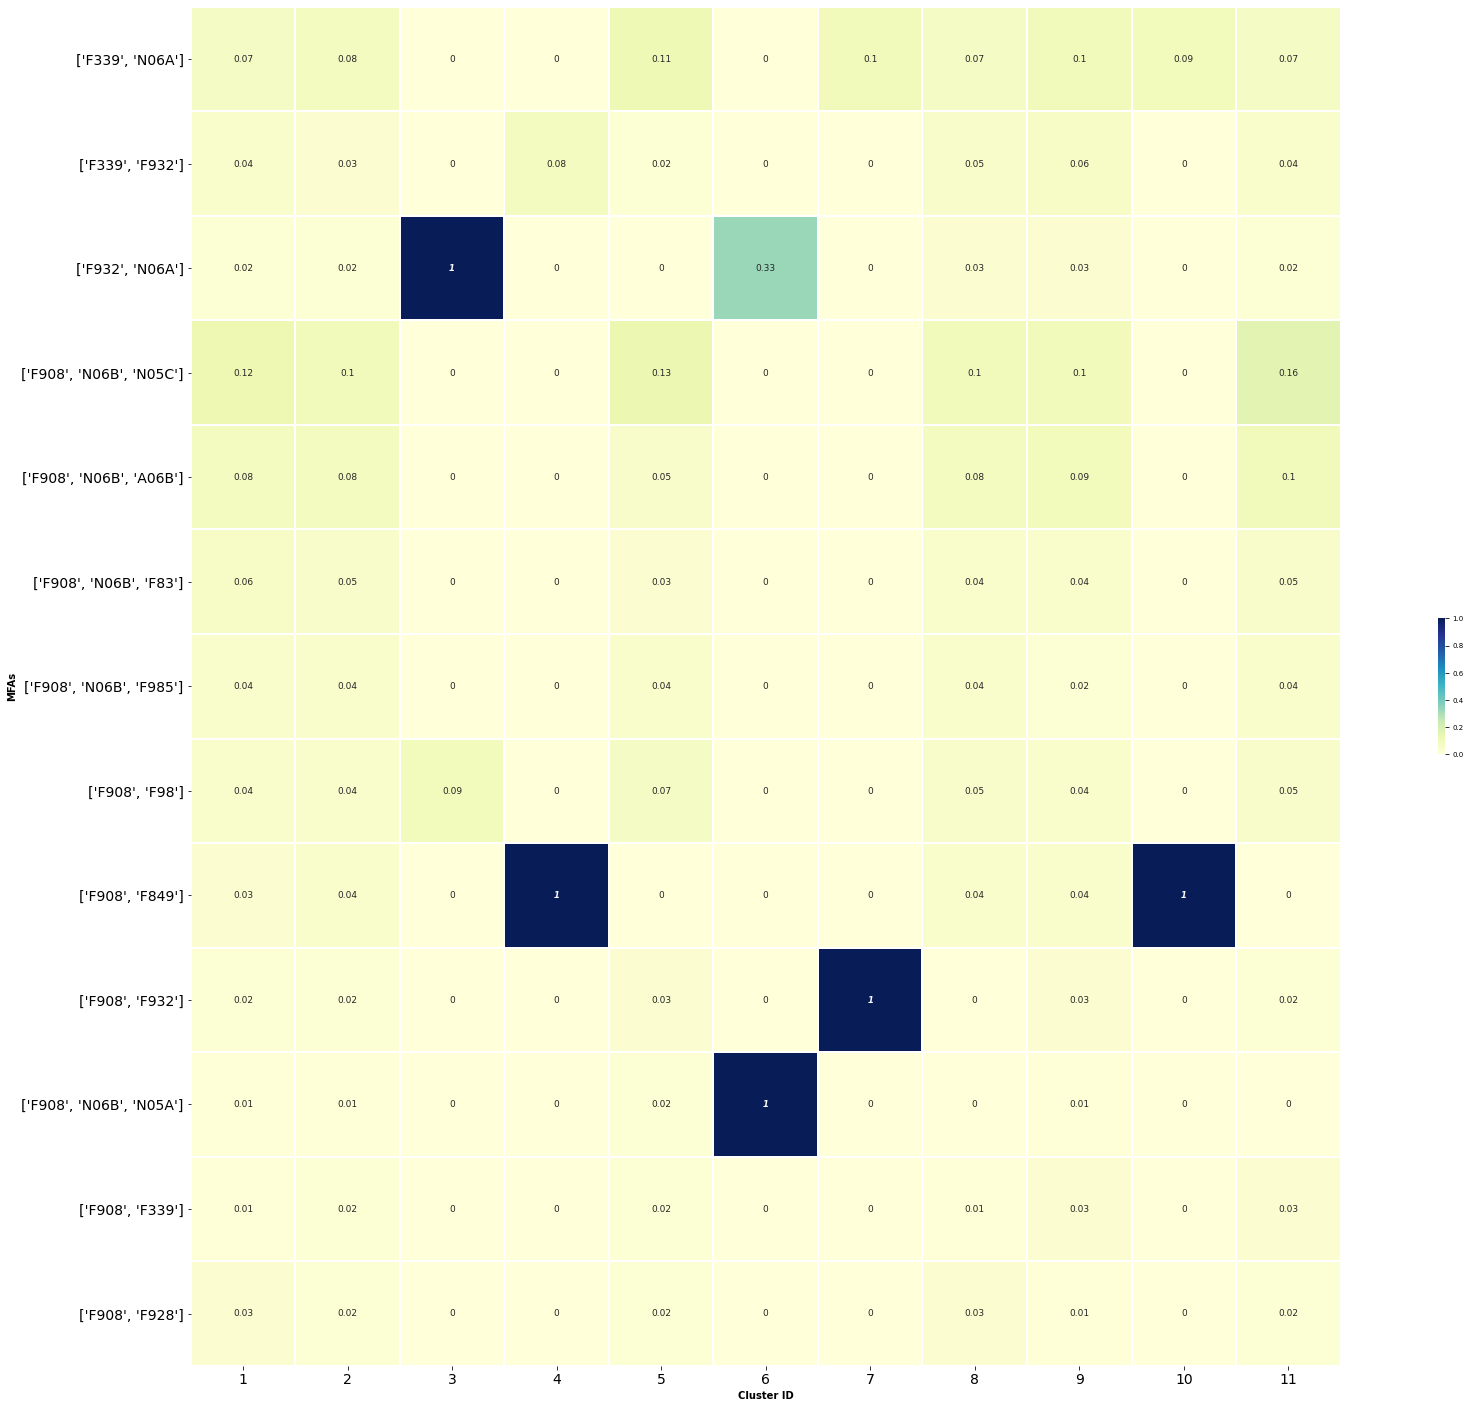

In [130]:
# Heatmap for patterns
plt.figure(figsize=(35, 25))
plt.rc('xtick', labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)  
plt.yticks(rotation=75) 
plt.rc('axes', labelsize=10, linewidth=1)
y_axis_labels = convertback_to_icd_atc(clusteredData.columns[6:len(mfas)+6]) 
x_axis_labels = list(range(1, k+1))


ax = sns.heatmap(np.round(heat_map_MFAs, 2), cmap="YlGnBu", square= True, annot=True, fmt=".2g", annot_kws={"fontsize": 9}, cbar=True, cbar_kws={"shrink": .1}, linewidths=.1, xticklabels=x_axis_labels , yticklabels=y_axis_labels)
plt.xlabel('Cluster ID', fontweight='bold')
plt.ylabel('MFAs', fontweight='bold')

for text in ax.texts: 
    text.set_size(9)
    if float(text.get_text()) >= 0.5: 
        text.set_size(8.5)
        text.set_weight('bold')
        text.set_style('italic')
#plt.savefig('/home/kabank/workbench/.conda/analysis/ias_Diagrams/mfaHEATMAP.pdf',bbox_inches="tight")

In [132]:
shap_df = binaryData_df.drop(["label"], axis=1)
shap_df = shap_df.drop(["episode_id"], axis=1)
shap_df.columns

Index(['MiddleChildhood', 'Preschooler', 'Teenager', 'F', 'M',
       '['29622', '999140601']', '['29622', '3001']', '['3001', '999140601']',
       '['3131', '999140602', '999140503']',
       '['3131', '999140602', '999010602']', '['3131', '999140602', '3151']',
       '['3131', '999140602', '3132']', '['3131', '313']', '['3131', '3133']',
       '['3131', '3001']', '['3131', '999140602', '999140501']',
       '['3131', '29622']', '['3131', '312']'],
      dtype='object')

In [133]:
column_list = shap_df.columns[5:].tolist()
print(len(column_list))
column_list
column_list2 = []
for item in column_list:
    itemlist = []
    #print(item)
    itemlist.append(item)
    column_list2.append(convertback_to_icd_atc(itemlist))
print(column_list2)


for i in range(5,5+len(column_list)):
    print(shap_df.columns[i], column_list2[i-5])

13
[[['F339', 'N06A']], [['F339', 'F932']], [['F932', 'N06A']], [['F908', 'N06B', 'N05C']], [['F908', 'N06B', 'A06B']], [['F908', 'N06B', 'F83']], [['F908', 'N06B', 'F985']], [['F908', 'F98']], [['F908', 'F849']], [['F908', 'F932']], [['F908', 'N06B', 'N05A']], [['F908', 'F339']], [['F908', 'F928']]]
['29622', '999140601'] [['F339', 'N06A']]
['29622', '3001'] [['F339', 'F932']]
['3001', '999140601'] [['F932', 'N06A']]
['3131', '999140602', '999140503'] [['F908', 'N06B', 'N05C']]
['3131', '999140602', '999010602'] [['F908', 'N06B', 'A06B']]
['3131', '999140602', '3151'] [['F908', 'N06B', 'F83']]
['3131', '999140602', '3132'] [['F908', 'N06B', 'F985']]
['3131', '313'] [['F908', 'F98']]
['3131', '3133'] [['F908', 'F849']]
['3131', '3001'] [['F908', 'F932']]
['3131', '999140602', '999140501'] [['F908', 'N06B', 'N05A']]
['3131', '29622'] [['F908', 'F339']]
['3131', '312'] [['F908', 'F928']]


In [134]:
if len(column_list2) >= len(column_list):
    for i in range(5, 5+len(column_list)):
        shap_df.columns.values[i] = column_list2[i-5][0]

    print(shap_df.columns)
else:
    print("Please provide enough code to replace.")


Index(['MiddleChildhood', 'Preschooler', 'Teenager', 'F', 'M',
       ['F339', 'N06A'], ['F339', 'F932'], ['F932', 'N06A'],
       ['F908', 'N06B', 'N05C'], ['F908', 'N06B', 'A06B'],
       ['F908', 'N06B', 'F83'], ['F908', 'N06B', 'F985'], ['F908', 'F98'],
       ['F908', 'F849'], ['F908', 'F932'], ['F908', 'N06B', 'N05A'],
       ['F908', 'F339'], ['F908', 'F928']],
      dtype='object')


In [135]:
shap_df.values

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [136]:
len(shap_df)

5889

In [137]:
shap_df.columns

Index(['MiddleChildhood', 'Preschooler', 'Teenager', 'F', 'M',
       ['F339', 'N06A'], ['F339', 'F932'], ['F932', 'N06A'],
       ['F908', 'N06B', 'N05C'], ['F908', 'N06B', 'A06B'],
       ['F908', 'N06B', 'F83'], ['F908', 'N06B', 'F985'], ['F908', 'F98'],
       ['F908', 'F849'], ['F908', 'F932'], ['F908', 'N06B', 'N05A'],
       ['F908', 'F339'], ['F908', 'F928']],
      dtype='object')

ICD codes and ATC codes with demographics

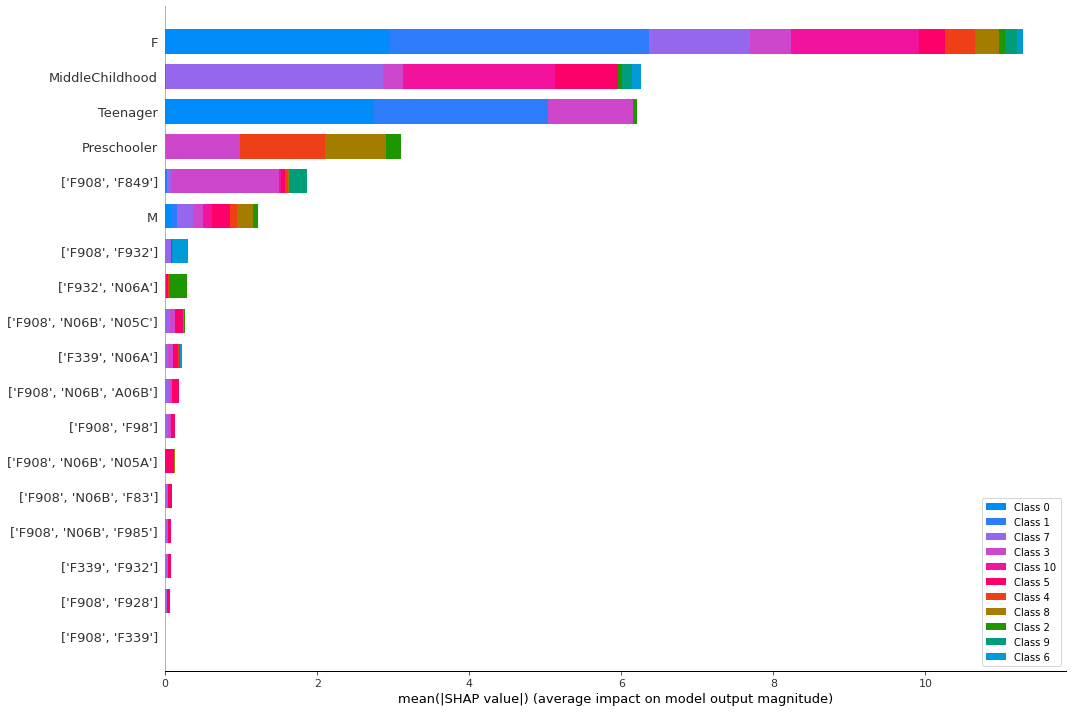

In [139]:
# SHAP Summaryplot showing how much each feature affect the results
# https://towardsdatascience.com/how-to-make-clustering-explainable -1582390476cc
y = binaryData_df["label"]
clf = LGBMClassifier(objective="binary")
clf.fit(shap_df , y)
explainer = shap.TreeExplainer(clf) 
shap_values = explainer.shap_values(shap_df)

# summarize the effects of all the features
plt.figure(figsize=(15, 7))
shap.summary_plot(shap_values, shap_df, plot_type="bar", plot_size=(15, 10), show=False)

# Get the current axes
ax = plt.gca()

# Get the current legend
legend = ax.get_legend()

# Set the legend's position to 'lower right'
ax.legend(loc='lower right')

plt.show()




In [140]:
binaryData_df.head()

,episode_id,MiddleChildhood,Preschooler,Teenager,F,M,"['29622', '999140601']","['29622', '3001']","['3001', '999140601']","['3131', '999140602', '999140503']","['3131', '999140602', '999010602']","['3131', '999140602', '3151']","['3131', '999140602', '3132']","['3131', '313']","['3131', '3133']","['3131', '3001']","['3131', '999140602', '999140501']","['3131', '29622']","['3131', '312']",label
1,7.0,0,0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,8.0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
6,16.0,0,0,1,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
7,22.0,0,0,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
8,23.0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


ICD codes and ATC codes without demographics

In [141]:
shap_df2 = binaryData_df.drop(["label", "episode_id", "MiddleChildhood", "Preschooler", "Teenager","F", "M"], axis=1)

In [142]:
shap_df2

,"['29622', '999140601']","['29622', '3001']","['3001', '999140601']","['3131', '999140602', '999140503']","['3131', '999140602', '999010602']","['3131', '999140602', '3151']","['3131', '999140602', '3132']","['3131', '313']","['3131', '3133']","['3131', '3001']","['3131', '999140602', '999140501']","['3131', '29622']","['3131', '312']"
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
column_list = shap_df2.columns[:].tolist()
print(len(column_list))
column_list
column_list2 = []
for item in column_list:
    itemlist = []
    #print(item)
    itemlist.append(item)
    column_list2.append(convertback_to_icd_atc(itemlist))
print(column_list2)
print("***")


for i in range(len(column_list)):
    print(shap_df2.columns[i], column_list2[i])

13
[[['F339', 'N06A']], [['F339', 'F932']], [['F932', 'N06A']], [['F908', 'N06B', 'N05C']], [['F908', 'N06B', 'A06B']], [['F908', 'N06B', 'F83']], [['F908', 'N06B', 'F985']], [['F908', 'F98']], [['F908', 'F849']], [['F908', 'F932']], [['F908', 'N06B', 'N05A']], [['F908', 'F339']], [['F908', 'F928']]]
***
['29622', '999140601'] [['F339', 'N06A']]
['29622', '3001'] [['F339', 'F932']]
['3001', '999140601'] [['F932', 'N06A']]
['3131', '999140602', '999140503'] [['F908', 'N06B', 'N05C']]
['3131', '999140602', '999010602'] [['F908', 'N06B', 'A06B']]
['3131', '999140602', '3151'] [['F908', 'N06B', 'F83']]
['3131', '999140602', '3132'] [['F908', 'N06B', 'F985']]
['3131', '313'] [['F908', 'F98']]
['3131', '3133'] [['F908', 'F849']]
['3131', '3001'] [['F908', 'F932']]
['3131', '999140602', '999140501'] [['F908', 'N06B', 'N05A']]
['3131', '29622'] [['F908', 'F339']]
['3131', '312'] [['F908', 'F928']]


In [144]:
if len(column_list2) >= len(column_list):
    for i in range(len(column_list)):
        shap_df2.columns.values[i] = column_list2[i][0]

    print(shap_df2.columns)
else:
    print("Please provide enough code to replace.")


Index([['F339', 'N06A'], ['F339', 'F932'], ['F932', 'N06A'],
       ['F908', 'N06B', 'N05C'], ['F908', 'N06B', 'A06B'],
       ['F908', 'N06B', 'F83'], ['F908', 'N06B', 'F985'], ['F908', 'F98'],
       ['F908', 'F849'], ['F908', 'F932'], ['F908', 'N06B', 'N05A'],
       ['F908', 'F339'], ['F908', 'F928']],
      dtype='object')


In [146]:
y = binaryData_df["label"]
len(y)

5889

In [147]:
print(shap_df2.values)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


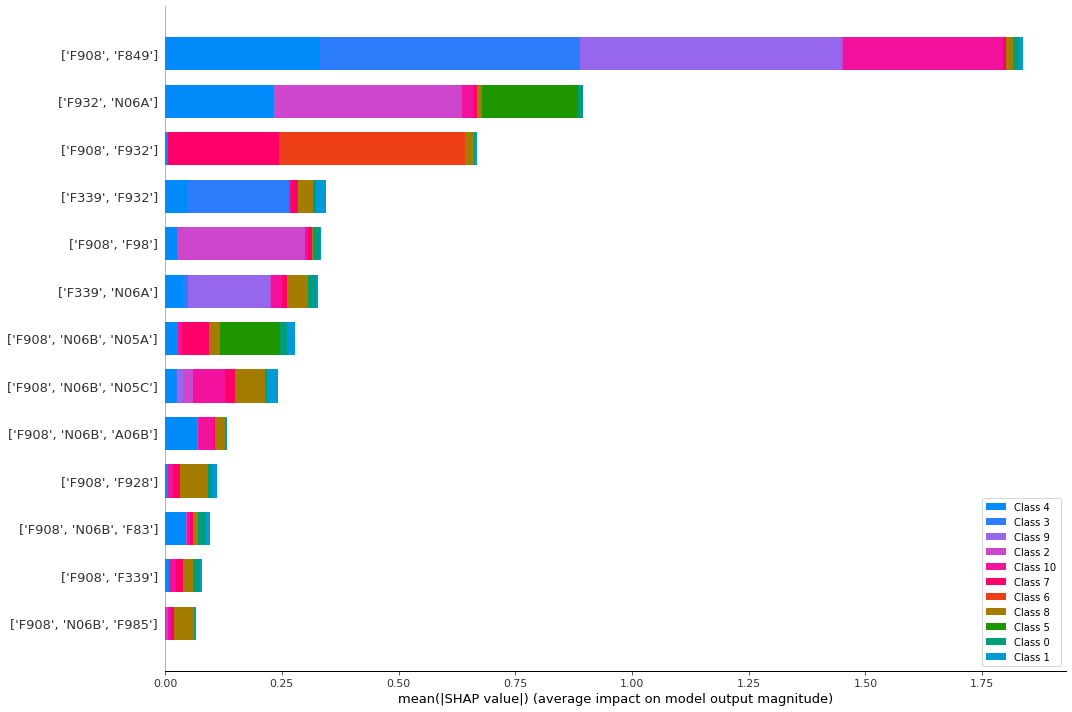

In [148]:
# SHAP Summaryplot showing how much each feature affect the results
# https://towardsdatascience.com/how-to-make-clustering-explainable -1582390476cc
y = binaryData_df["label"]
clf = LGBMClassifier(objective="binary")
clf.fit(shap_df2 , y)
explainer = shap.TreeExplainer(clf) 
shap_values = explainer.shap_values(shap_df2)

# summarize the effects of all the features
plt.figure(figsize=(15, 7))
shap.summary_plot(shap_values , shap_df2 , plot_type="bar",plot_size=(15, 10), show=False) 
# Get the current axes
ax = plt.gca()

# Get the current legend
legend = ax.get_legend()

# Set the legend's position to 'lower right'
ax.legend(loc='lower right')

plt.show()